# Filtering is necessary

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [51]:
import corc.utils
import corc.graph_metrics.neb
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib

In [3]:
# dataset_name = "varied"
# dataset_name = "clusterlab10"
# dataset_name = "aniso"
dataset_name = "blobs"

X,y,_ = corc.utils.load_dataset(dataset_name, cache_path="../../cache")

In [4]:
tmm_model = corc.graph_metrics.neb.NEB(
    data=X,
    labels=y,
    n_components=30,
    optimization_iterations=10,
    min_cluster_size=0,
    tmm_regularization=1e-8,
    max_elongation=np.inf
)
tmm_model.fit(X)

2025-01-17 11:12:35.447365: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[[    9    35]
 [   53     2]
 [   45     1]
 [   19    38]
 [   35     5]
 [   26     7]
 [    3 30173]
 [   50     3]
 [    3  1929]
 [    4   331]
 [   44     7]
 [   77     5]
 [   64     4]
 [   39    21]
 [    4 19542]
 [   38     2]
 [   22     1]
 [   27     4]
 [   17    21]
 [   36     4]
 [   75     3]
 [   24   174]
 [    4  2676]
 [   30     4]
 [   16     4]
 [   63     3]
 [   36     1]
 [   51    10]
 [   66    11]
 [   20   158]]
After filtering 30 components, we are left with 30 components


tmm: 100%|██████████| 150/150 [00:20<00:00,  7.44it/s]

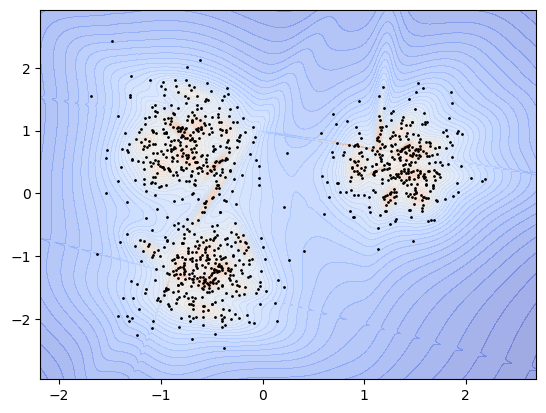

In [16]:
plot_field(X,tmm_model.mixture_model,levels=60, grid_resolution=1024)

In [89]:
mixture_model = copy.deepcopy(tmm_model.mixture_model)

In [35]:
def filter_mixture(mixture_model, data_X, min_cluster_size=10, max_elongation=1000):
        # compute elongations and cluster sizes
        counts = mixture_model.get_counts(data_X)
        elongations = mixture_model.get_elongations()

        # construct filter (True will be kept)
        component_filter = np.logical_and(
            counts > min_cluster_size, np.array(elongations) > max_elongation
        )

        # filter the components
        mixture_model.centers = mixture_model.centers[component_filter]
        mixture_model.covs = mixture_model.covs[component_filter]
        mixture_model.weights = mixture_model.weights[component_filter]

In [128]:
filter_mixture(mixture_model,X,min_cluster_size=0, max_elongation=160)

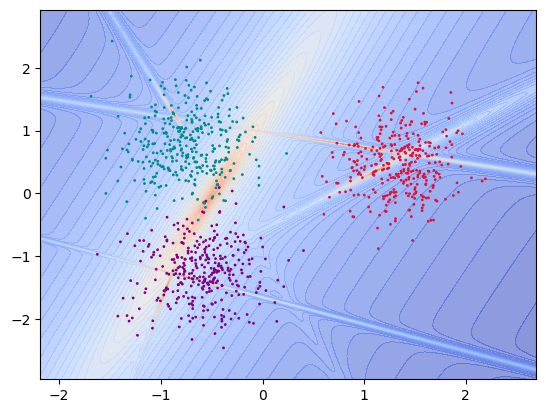

In [130]:

def plot_field(
    data_X,
    data_y,
    mixture_model,
    levels=20,
    paths=None,  # storage of all paths
    selection=None,  # selection which paths to plot
    save_path=None,
    axis=None,
    plot_points=True,  # whether data_X is plotted
    transformed_points=None,
    grid_resolution=128,
):
    """Plots the TMM/GMM field and the optimized paths (if available).
    selection: selects which paths are included in the plot, by default, all paths are included.
      other typical options: MST through selection=zip(mst.row,mst.col) and individuals via e.g. [(0,1), (3,4)]

    """
    if axis is None:
        figure, axis = plt.subplots(1, 1)

    # Compute TSNE if necessary
    if data_X.shape[-1] > 2:
        if transformed_points is None:
            transformed_points = corc.utils.get_TSNE_embedding(data_X)
        locations = corc.utils.snap_points_to_TSNE(
            locations, data_X, transformed_points
        )
    else:
        transformed_points = data_X

    # plot the energy landscape if possible
    if data_X.shape[-1] == 2:
        # grid coordinates
        margin = 0.5
        x = np.linspace(
            data_X[:, 0].min() - margin, data_X[:, 0].max() + margin, grid_resolution
        )
        y = np.linspace(
            data_X[:, 1].min() - margin, data_X[:, 1].max() + margin, grid_resolution
        )
        XY = np.stack(np.meshgrid(x, y), -1)

        # get scores for the grid values
        mm_probs = mixture_model.score_samples(XY.reshape(-1, 2)).reshape(
            grid_resolution, grid_resolution
        )
        # plotting the energy landscape
        axis.contourf(
            x,
            y,
            mm_probs,
            levels=levels,
            cmap="coolwarm",
            alpha=0.6,
            zorder=-10,
        )

    # plot the raw data
    if plot_points:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkcyan", "purple", "crimson"])
        axis.scatter(
            transformed_points[:, 0], 
            transformed_points[:, 1], 
            s=1, 
            label="raw data",
            c=data_y,
            cmap=cmap
        )
fig, ax = plt.subplots()
plot_field(X,y,mixture_model,levels=60, grid_resolution=1024,axis=ax)
plt.savefig("../../figures/filtering1.pdf")
plt.savefig("../../figures/filtering1.png")
plt.show()


In [100]:
mixture_model.centers

array([[-0.71111696, -1.34695281],
       [-0.87403087,  1.27012461],
       [ 1.10914584,  0.35418782],
       [ 0.8949992 ,  0.76071726],
       [-0.50999938, -0.06179248],
       [-0.95125924, -1.5327956 ],
       [ 1.14821044,  0.91534514]])

In [101]:
mixture_model.weights

array([0.00235871, 0.00302653, 0.00431506, 0.00410294, 0.02588624,
       0.00407543, 0.01967398])

In [92]:
mixture_model.get_elongations()

[30173.652645785867,
 1929.602819351182,
 331.59112217387684,
 19542.4503572845,
 174.0415639207397,
 2676.5615106904743,
 158.1487549669755]

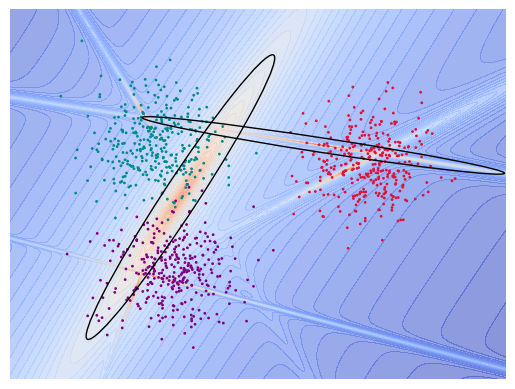

In [136]:
index =4
eigenvalues, eigenvectors = np.linalg.eig(mixture_model.covs[index])
width = 15* np.sqrt(eigenvalues[0])
height = 15 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse = matplotlib.patches.Ellipse(mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")

index =3
eigenvalues, eigenvectors = np.linalg.eig(mixture_model.covs[index])
width = 58* np.sqrt(eigenvalues[0])
height = 500 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse2 = matplotlib.patches.Ellipse(mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")



fig, ax = plt.subplots()
plot_field(X,y,mixture_model,levels=60, grid_resolution=1024,axis=ax)
ax.add_patch(ellipse)
ax.add_patch(ellipse2)
plt.axis('off')
plt.savefig("../../figures/filtering1.pdf",bbox_inches="tight")
plt.savefig("../../figures/filtering1.png",bbox_inches="tight")
plt.show()

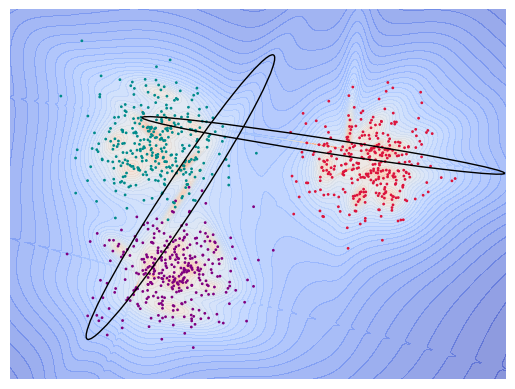

In [133]:
# Calculate the eigenvalues and eigenvectors of the covariance matrix
index =4
eigenvalues, eigenvectors = np.linalg.eig(mixture_model.covs[index])
width = 15* np.sqrt(eigenvalues[0])
height = 15 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse = matplotlib.patches.Ellipse(mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")

index =3
eigenvalues, eigenvectors = np.linalg.eig(mixture_model.covs[index])
width = 58* np.sqrt(eigenvalues[0])
height = 500 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse2 = matplotlib.patches.Ellipse(mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")


fig, ax = plt.subplots()
plot_field(X,y,tmm_model.mixture_model,levels=60, grid_resolution=1024,axis=ax)
ax.add_patch(ellipse)
ax.add_patch(ellipse2)
plt.axis('off')
plt.savefig("../../figures/filtering2.pdf",bbox_inches="tight")
plt.savefig("../../figures/filtering2.png",bbox_inches="tight")
plt.show()

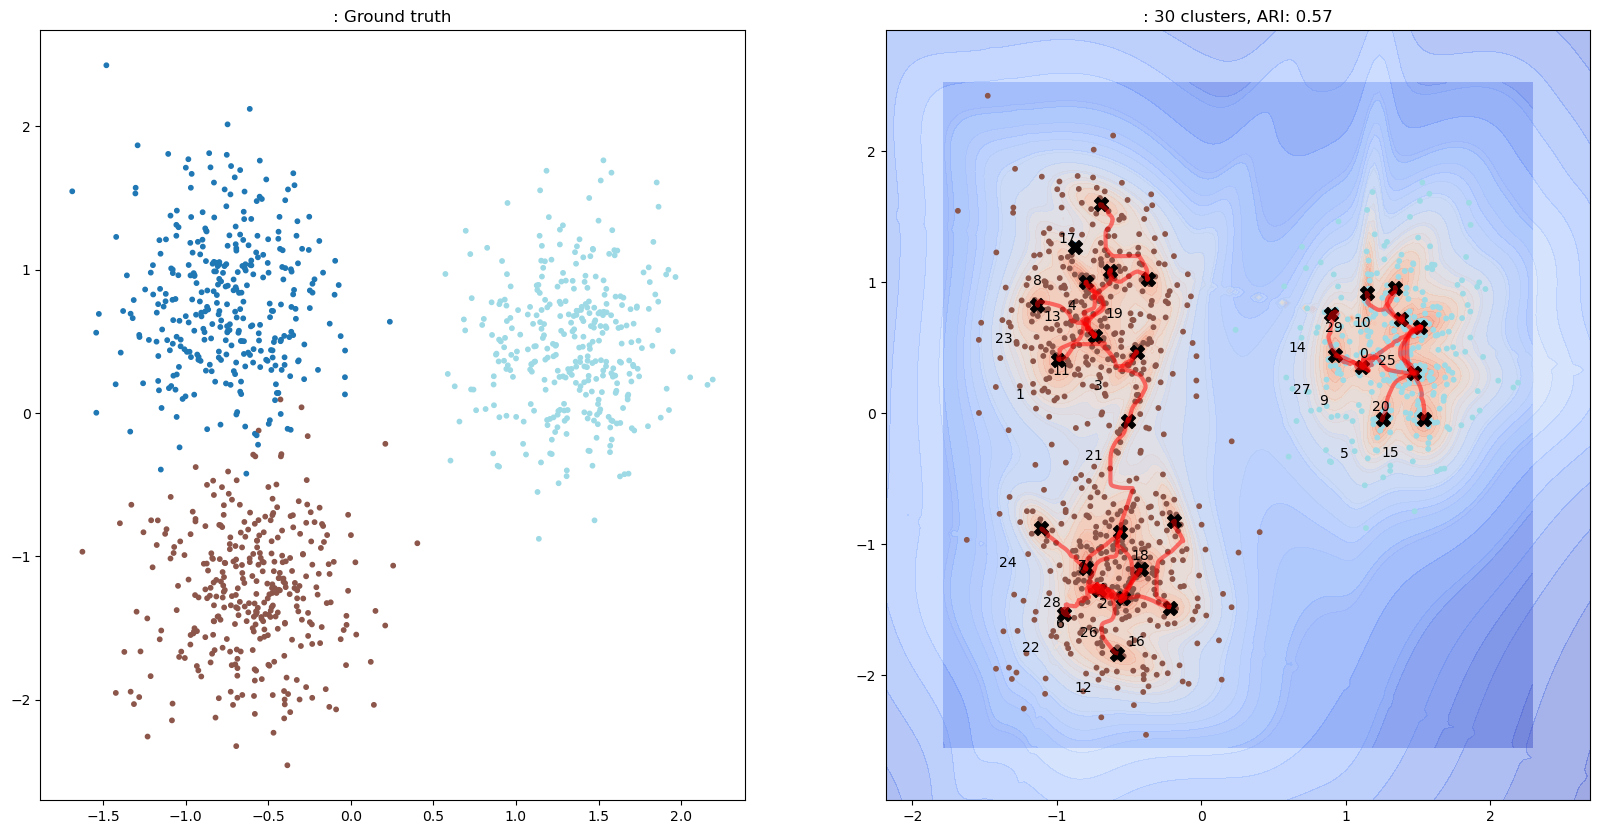

In [21]:
import corc.tmm_plots


plot = corc.tmm_plots.plot_tmm_models([tmm_model],X,y,"")